In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

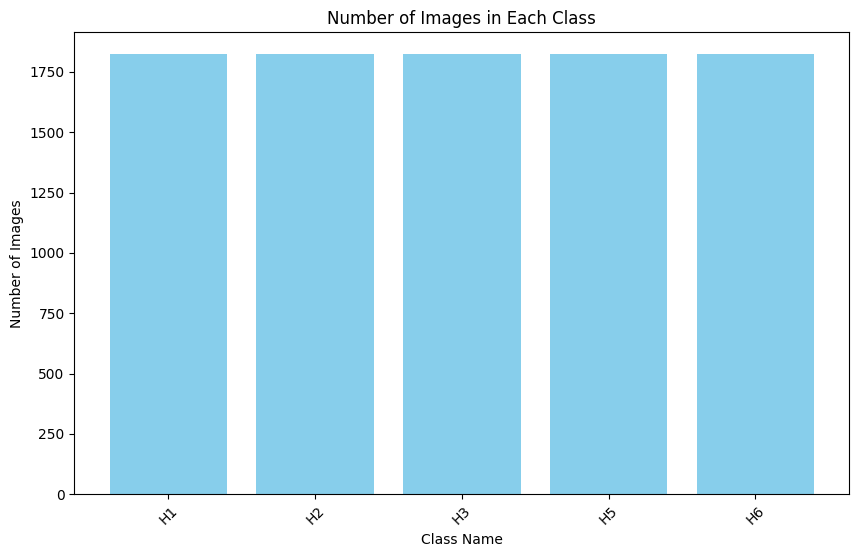

In [5]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()



In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names


Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [7]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  

model = Model(inputs=vgg_base.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [12]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,
    verbose=1
).history

# Print model summary
model.summary()

Epoch 1/60
29/29 [==============================] - 871s 30s/step - loss: 1.3183 - accuracy: 0.5221 - val_loss: 0.8902 - val_accuracy: 0.6612
Epoch 2/60
29/29 [==============================] - 775s 27s/step - loss: 0.9143 - accuracy: 0.6329 - val_loss: 0.7907 - val_accuracy: 0.6908
Epoch 3/60
29/29 [==============================] - 771s 27s/step - loss: 0.8107 - accuracy: 0.6682 - val_loss: 0.7329 - val_accuracy: 0.7198
Epoch 4/60
29/29 [==============================] - 771s 27s/step - loss: 0.7519 - accuracy: 0.6985 - val_loss: 0.6774 - val_accuracy: 0.7467
Epoch 5/60
29/29 [==============================] - 776s 27s/step - loss: 0.7084 - accuracy: 0.7165 - val_loss: 0.6466 - val_accuracy: 0.7489
Epoch 6/60
29/29 [==============================] - 781s 27s/step - loss: 0.6582 - accuracy: 0.7346 - val_loss: 0.6306 - val_accuracy: 0.7604
Epoch 7/60
29/29 [==============================] - 771s 27s/step - loss: 0.6454 - accuracy: 0.7374 - val_loss: 0.6082 - val_accuracy: 0.7719
Epoch 

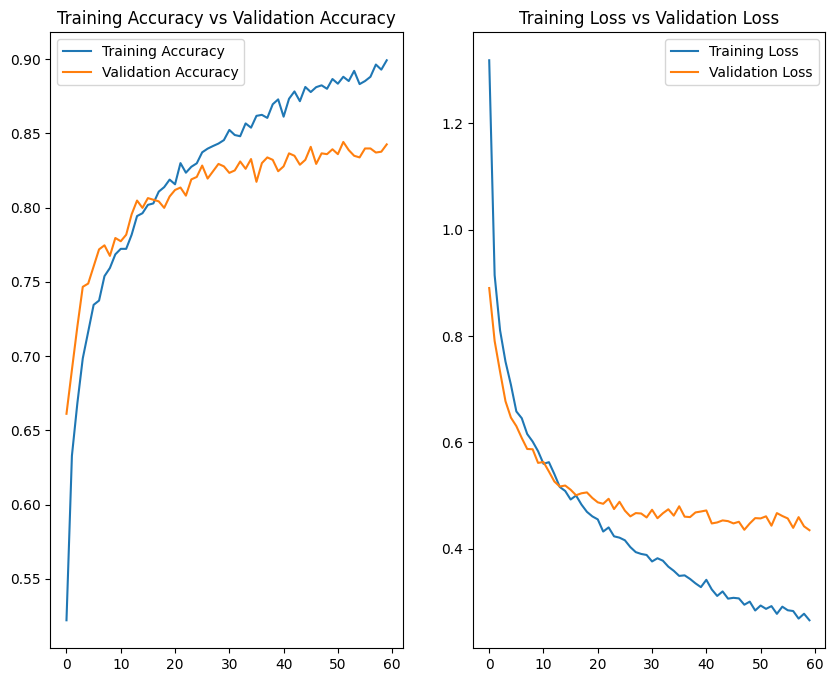

In [17]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(60),acc,label='Training Accuracy')
plt.plot(range(60),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(60),loss,label='Training Loss')
plt.plot(range(60),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [16]:
model.save("vgg1.h5")

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/vgg1.h5",compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 192s 23s/step - loss: 0.4350 - accuracy: 0.8427
Test Loss: 0.43498149514198303
Test Accuracy: 0.8426535129547119


In [9]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)


8/8 [==============================] - 288s 34s/step
Classification Report:
              precision    recall  f1-score   support

          H1       0.83      0.93      0.88       881
          H2       0.79      0.67      0.73       467
          H3       0.83      0.77      0.80       164
          H5       0.94      0.91      0.93       164
          H6       0.94      0.91      0.92       148

    accuracy                           0.84      1824
   macro avg       0.87      0.84      0.85      1824
weighted avg       0.84      0.84      0.84      1824



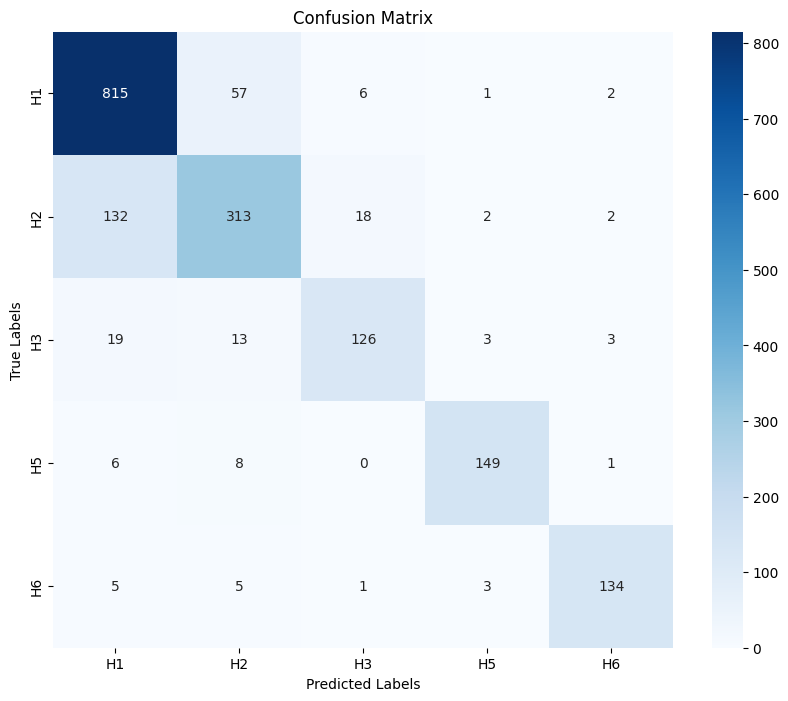

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

8/8 [==============================] - 185s 23s/step
Precision: 0.8416692353896409
Recall: 0.8426535087719298
F1-score: 0.8395777877692081


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)

1/1 [==============================] - 0s 94ms/step
Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H2
